# Collect data DONE
# Cleanup data DONE
# WordCloud DONE 
# Sentiment (Vader) -> check rougness of lyrics per year/ check number of abcense words
# topic modelling DONE
# Web wiki db -> plot map of relation between birth place and artists in top rank
# Train NN T5 DONE


# Setup

In [1]:
!pip install -U pip setuptools wheel --quiet

In [2]:
!pip install torch --quiet
!pip install sklearn --quiet
!pip install datasets --quiet
!apt install git-lfs --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



In [3]:
!pip install rouge --quiet

In [4]:
!pip install nltk --quiet
!pip install gensim --quiet
!pip install -U spacy==2.3.9 --quiet

In [5]:
!python3 -m spacy download en --quiet

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz#egg=en_core_web_sm==2.3.1 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/macbook_pro/Documents/GitHub/lyrics-sentiment-analysis/venv/lib/python3.9/site-packages/en_core_web_sm
-->
/Users/macbook_pro/Documents/GitHub/lyrics-sentiment-analysis/venv/lib/python3.9/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install ipympl --quiet
!pip install mpld3 --quiet
!pip install scikit-learn --quiet
!pip install statsmodels --quiet
!pip install scipy --quiet
!pip install wordcloud --quiet

In [7]:
!pip install beautifulsoup4 --quiet
!pip install lyricsgenius --quiet
!pip install billboard.py --quiet

In [8]:
!pip install pyLDAvis --quiet

In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv
import dotenv
import os
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [ ]:
# Import Genious access token

In [ ]:
load_dotenv(os.path.join(os.getcwd(),'.env'))
GENIOUS_ACCESS_TOKEN = os.environ.get('GENIOUS_ACCESS_TOKEN')

In [21]:
import pandas as pd
import numpy as np
import requests

# import seaborn as sns
from IPython.display import HTML, display
from bs4 import BeautifulSoup

import lyricsgenius as genius
import billboard
import sys
import re
import ast
import os

import nltk
from nltk.translate.bleu_score import sentence_bleu
# if not nltk.data.find('corpora/stopwords'):
#     # Download the 'stopwords' dataset
#     nltk.download('stopwords')
from nltk.corpus import stopwords
from rouge import Rouge

from datetime import datetime, date, timedelta
from wordcloud import WordCloud,ImageColorGenerator
%matplotlib inline
%matplotlib notebook
%pylab
# %matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
import statsmodels.api as sm
# from collections import Counter
# from os import path
# from PIL import Image
# from keras.models import model_from_json
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import pyLDAvis
import pyLDAvis.gensim_models


# for t5
import torch
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import T5ForConditionalGeneration, T5Tokenizer
import random
from tqdm.auto import tqdm, trange
from huggingface_hub import notebook_login

# for w2v
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import mpld3


Using matplotlib backend: module://ipympl.backend_nbagg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/macbook_pro/Documents/GitHub/lyrics-sentiment-analysis/venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['scatter', 'datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
def disable_pandas_warnings():
    import warnings
    warnings.resetwarnings()  # Maybe somebody else is messing with the warnings system?
    warnings.filterwarnings('ignore')  # Ignore everything
    # ignore everything does not work: ignore specific messages, using regex
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings('ignore', '.*A value is trying to be set on a copy of a slice from a DataFrame.*')
    warnings.filterwarnings('ignore', '.*indexing past lexsort depth may impact performance*')

In [ ]:
disable_pandas_warnings()

# Data Collecting

In [ ]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days // 7)):
        yield start_date + timedelta(n*7)

In [ ]:
def collect_songs_from_billboard_each_day(start_date_str, end_date_str, chart_name='hot-100', table_path = None,to_csv = False):
    start_date = datetime.strptime(
        start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    columns = ["Rank",
                    "Song Title",
                    "Artist",
                    "Date",
                    "Year"]
    dataset = pd.DataFrame(columns = columns, data = [])
    if to_csv:
        dataset.to_csv(table_path,index=False)

    sys.stdout.write(
        "\r" + "Collecting Songs from " + start_date_str + " to " + end_date_str + " via https://www.billboard.com")
    sys.stdout.flush()
    for single_date in tqdm(daterange(start_date, end_date)):
        print(single_date.strftime('%Y-%m-%d'))
        chart = billboard.ChartData(chart_name, date=single_date.strftime('%Y-%m-%d'))
        for song in chart:
            row = {
                "Rank": song.rank,
                "Song Title": song.title,
                "Artist": song.artist,
                "Date": single_date.strftime('%Y-%m-%d'),
                "Year": single_date.strftime('%Y')
            }
            if to_csv:
                pd.DataFrame([row]).to_csv(table_path, mode='a',index=False, header=False)
            else:
                dataset = dataset.append(row, ignore_index=True)  #pd.concat([dataset,pd.DataFrame(row)],ignore_index=True)#
    if not to_csv:
        return dataset


In [ ]:
all_songs = collect_songs_from_billboard_each_day('2003-02-17', '2023-02-17',table_path='all_songs_20.csv',to_csv = True)

In [ ]:
all_songs = pd.read_csv("all_songs_20.csv")

In [ ]:
all_songs.head(70)

,Rank,Song Title,Artist,Date,Year
0,1,All I Have,Jennifer Lopez Featuring LL Cool J,2003-02-17,2003
1,2,In Da Club,50 Cent,2003-02-17,2003
2,3,Mesmerize,Ja Rule Featuring Ashanti,2003-02-17,2003
3,4,"Bump, Bump, Bump",B2K & P. Diddy,2003-02-17,2003
4,5,Cry Me A River,Justin Timberlake,2003-02-17,2003
...,...,...,...,...,...
65,66,No Letting Go,Wayne Wonder,2003-02-17,2003
66,67,Make It Clap,Busta Rhymes Featuring Spliff Star,2003-02-17,2003
67,68,Can't Stop,Red Hot Chili Peppers,2003-02-17,2003
68,69,What Happened To That Boy,Baby Featuring Clipse,2003-02-17,2003


In [ ]:
all_songs["Artist"][all_songs['Artist'] == "Jackson 5"] = "The Jackson 5"
all_songs["Artist"][all_songs['Artist'] == "Beatles"] = "The Beatles"

In [ ]:
all_songs.drop_duplicates(subset=['Artist','Song Title']).to_csv('unique_songs_20.csv', mode='a',index=False)

In [ ]:
api = genius.Genius(GENIOUS_ACCESS_TOKEN,timeout = 5, sleep_time=0.015, verbose=False)

In [ ]:
all_songs = pd.read_csv("unique_songs_20.csv")

GENIOUS_CSV = 'all_songs_data_new.csv'
columns = [ "Year",
        "Rank",
        "Song Title",
        "Artist",
        "Primary Artists",
        "Lyrics",
        "Song URL",
        "Song id",
        "Song stats",
        "Song annotations"]
dataset = pd.DataFrame(columns = columns, data = [])
dataset.to_csv(GENIOUS_CSV,index=False)


all_song_data = pd.DataFrame()
start_time = datetime.now()
print("Started at {}".format(start_time))
for i in range(0, len(all_songs)):
    rolling_pct = int((i / len(all_songs)) * 100)
    # print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) + " of " +
    #       str(len(all_songs)) + ". Year " + str(all_songs.iloc[i]['Year']) + "." + " Currently collecting " +
    #       all_songs.iloc[i]['Song Title'] + " by " + all_songs.iloc[i]['Artist'] + " " * 50, end="\r")
    song_title = all_songs.iloc[i]['Song Title']
    song_title = re.sub(" and ", " & ", song_title)
    artist_name = all_songs.iloc[i]['Artist']
    artist_name = re.sub(" and ", " & ", artist_name)

    try:
        song = api.search_song(song_title, artist=artist_name)
        primary_artists = song.primary_artist
        song_lyrics = re.sub("\n", " ", song.lyrics)  #Remove newline breaks, we won't need them.
        song_url = song.url
        song_id = song.id
        song_stats = song.stats
        song_annotations = api.song_annotations(song.id)
    except:
        primary_artists = "null"
        song_lyrics = "null"
        song_url = "null"
        song_id = "null"
        song_stats = 'null'
        song_annotations = 'null'

    row = {
        "Year": all_songs.iloc[i]['Year'],
        "Rank": all_songs.iloc[i]['Rank'],
        "Song Title": all_songs.iloc[i]['Song Title'],
        "Artist": all_songs.iloc[i]['Artist'],
        "Primary Artists": primary_artists,
        "Lyrics": song_lyrics,
        "Song URL": song_url,
        "Song id": song_id,
        "Song stats": song_stats,
        "Song annotations": song_annotations
    }
    pd.DataFrame([row]).to_csv(GENIOUS_CSV, mode='a',index=False, header=False)
    # all_song_data = all_song_data.append(row, ignore_index=True)
end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))


Started at 2023-03-18 15:38:32.176995

Completed at 2023-03-18 15:38:32.176995
Total time to collect: 5:20:57.880854


In [ ]:
all_song_data.tail(5)

,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats
6,2022,7,Kill Bill,SZA,"SZA, 0 songs",TranslationsEspañolPortuguêsItalianoTürkçeDeut...,https://genius.com/Sza-kill-bill-lyrics,8616820,"Stats('unreviewed_annotations, concurrents, ho..."
7,2022,8,Feliz Navidad,Jose Feliciano,"José Feliciano, 0 songs","Feliz Navidad Lyrics[Letra de ""Feliz Navidad""]...",https://genius.com/Jose-feliciano-feliz-navida...,623111,"Stats('unreviewed_annotations, hot, pageviews')"
8,2022,9,Anti-Hero,Taylor Swift,"Taylor Swift, 0 songs",TranslationsPortuguêsEspañolTürkçeFrançais中文Ne...,https://genius.com/Taylor-swift-anti-hero-lyrics,8434253,"Stats('unreviewed_annotations, concurrents, ho..."
9,2022,10,Unholy,Sam Smith & Kim Petras,"Sam Smith & Kim Petras, 0 songs",TranslationsFrançaisEspañolNederlandsDeutschال...,https://genius.com/Sam-smith-and-kim-petras-un...,8302862,"Stats('unreviewed_annotations, concurrents, ho..."
10,2022,11,The Christmas Song (Merry Christmas To You),Nat King Cole,"The Nat “King” Cole Trio, 0 songs",The Christmas Song (Merry Christmas to You) (O...,https://genius.com/The-nat-king-cole-trio-the-...,1717793,"Stats('unreviewed_annotations, hot, pageviews')"


In [ ]:
loaded_song_dataset = pd.read_csv("all_songs_data_new.csv")

In [ ]:
display(loaded_song_dataset.head())
display(loaded_song_dataset.tail())

,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats,Song annotations
0,2003,1,All I Have,Jennifer Lopez Featuring LL Cool J,"Jennifer Lopez, 0 songs","All I Have Lyrics[Intro: Jennifer Lopez, Sampl...",https://genius.com/Jennifer-lopez-all-i-have-l...,32015.0,"Stats('unreviewed_annotations, hot, pageviews')","[('Oh-oh-oh\n Uh, baby, don’t go\n All my, all..."
1,2003,2,In Da Club,50 Cent,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,3,Mesmerize,Ja Rule Featuring Ashanti,"Ja Rule, 0 songs","Mesmerize Lyrics[Intro: Ja Rule] Haha, yeah Wh...",https://genius.com/Ja-rule-mesmerize-lyrics,23989.0,"Stats('unreviewed_annotations, hot, pageviews')","[('Haha, yeah\n Whattup ma? How you been?\n Ye..."
3,2003,4,"Bump, Bump, Bump",B2K & P. Diddy,"B2K, 0 songs","Bump, Bump, Bump Lyrics[Intro: P. Diddy & B2K]...",https://genius.com/B2k-bump-bump-bump-lyrics,32117.0,"Stats('unreviewed_annotations, hot, pageviews')","[('(Come on, it’s ”Pandemonium”, baby)', [['Th..."
4,2003,5,Cry Me A River,Justin Timberlake,NaN,NaN,NaN,NaN,NaN,NaN


,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats,Song annotations
9035,2023,80,The Black Seminole.,Lil Yachty,"Lil Yachty, 0 songs",TranslationsEspañol​the BLACK seminole. Lyrics...,https://genius.com/Lil-yachty-the-black-semino...,8763573.0,"Stats('unreviewed_annotations, hot, pageviews')","[('African Rambo with more ammo', [['John Jame..."
9036,2023,86,Fin de Semana,Junior H X Oscar Maydon,NaN,NaN,NaN,NaN,NaN,NaN
9037,2023,96,Hey Mor,Ozuna Featuring Feid,"Ozuna, 0 songs","Hey Mor Lyrics[Letra de ""Hey Mor"" ft. Feid] [...",https://genius.com/Ozuna-hey-mor-lyrics,8400438.0,"Stats('unreviewed_annotations, hot, pageviews')",[]
9038,2023,99,Never Gonna Not Dance Again,P!nk,"P!nk, 0 songs",TranslationsItalianoNever Gonna Not Dance Agai...,https://genius.com/P-nk-never-gonna-not-dance-...,8475909.0,"Stats('unreviewed_annotations, hot, pageviews')","[('For once I wouldn’t start a fight', [['This..."
9039,2023,100,Dancin' In The Country,Tyler Hubbard,"Tyler Hubbard, 0 songs",Dancin’ In The Country Lyrics[Verse 1] Them ne...,https://genius.com/Tyler-hubbard-dancin-in-the...,8255170.0,"Stats('unreviewed_annotations, hot')",[]


In [ ]:
songs_with_lyrics_dataset = loaded_song_dataset.dropna(subset=['Lyrics'])
songs_with_lyrics_dataset.to_csv('all_songs_no_null.csv',index=False)

## Data cleaning

* Clean lyrics and save to csv

In [ ]:
# Define a regex pattern to match text before the word "Lyrics"
pattern = re.compile(r".*Lyrics", re.DOTALL)

# Define a function to clean the "Lyrics" column
def clean_lyrics(lyrics):
    # Remove all text before the word "Lyrics"
    cleaned_lyrics = re.sub(pattern, "Lyrics", lyrics)
    # Remove any text inside square brackets
    cleaned_lyrics = re.sub(r"\[.*?\]", "", cleaned_lyrics)
    # remove all occurances of word Lyrics
    cleaned_lyrics = re.sub(r"\bLyrics\b", "", cleaned_lyrics)
    cleaned_lyrics = re.sub(r"\bEmbed\b", "", cleaned_lyrics)
    # Return the cleaned lyrics
    return cleaned_lyrics

In [ ]:
loaded_song_dataset = pd.read_csv("all_songs_no_null.csv")

# Apply the clean_lyrics function to the "Lyrics" column of the DataFrame
loaded_song_dataset["Lyrics"] = loaded_song_dataset["Lyrics"].apply(clean_lyrics)

# Save the cleaned DataFrame to a new CSV file
loaded_song_dataset.to_csv('cleaned_songs.csv', index=False)

# Data Statistic

## Word Cloud

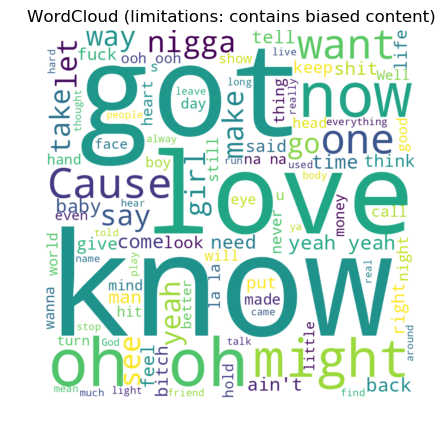

In [ ]:
# Create and generate a word cloud image:
df = pd.read_csv("cleaned_songs.csv")
lyrics_text = ' '.join(df['Lyrics'])

wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(str(lyrics_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud (limitations: contains biased content)")
plt.show()

## Profanity filter and Wordcloud

In [ ]:
bad_word_file = 'Facebook Bad Words List 2022.txt'
with open(bad_word_file) as f:
    bad_words = f.read().split(",")

In [ ]:
len(bad_words)

1110

In [ ]:
def clean_profanity_lyrics(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    # Remove stop words
    words = [word for word in words if word not in bad_words]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [ ]:
def clean_non_profanity(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    # Remove stop words
    words = [word for word in words if word in bad_words]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


In [ ]:
def tokenize_lyrics(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    return words

In [ ]:
df = pd.read_csv("cleaned_songs.csv")

df['Tokenized Lyrics'] = df['Lyrics'].apply(tokenize_lyrics)
df['Cleaned Lyrics'] = df['Lyrics'].apply(clean_profanity_lyrics)
df['Bad Words'] = df['Lyrics'].apply(clean_non_profanity)
df.to_csv('cleaned_songs.csv', index=False)

In [ ]:
def split_to_list_of_words(lyrics):
  return lyrics.split(' ')

In [ ]:
def join_to_string(lyrics):
  return " ".join(lyrics)

In [ ]:
df = pd.read_csv("cleaned_songs.csv")
df['Cleaned Lyrics List'] = df['Cleaned Lyrics'].apply(split_to_list_of_words)
df.to_csv('cleaned_songs.csv', index=False)

In [ ]:
def make_bigrams(lyrics):
    return [bigram_mod[doc] for doc in lyrics]

def make_trigrams(lyrics):
    return [trigram_mod[bigram_mod[doc]] for doc in lyrics]

def lemmatization(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts_out = []
    for sent in lyrics:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Build the bigram and trigram models
data_words =  pd.read_csv('cleaned_songs.csv')['Cleaned Lyrics List'].apply(ast.literal_eval)
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#! python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
df['Lemmatizated lyrics'] = data_lemmatized

# save progress
df.to_csv('cleaned_songs.csv', index=False)
print(data_lemmatized[:1])

[['life', 'life', 'live', 'special', 'love', 'baby', 'go', 'love', 'baby', 'go', 'special', 'baby', 'go', 'love', 'baby', 'go', 'baby', 'go', 'love', 'understand', 'baby', 'go', 'actin', 'shame', 'be', 'leave', 'can', 'take', 'way', 'mistreat', 'crazy', 'baby', 'come', 'matter', 'phase', 'believe', 'leave', 'believe', 'last', 'real', 'kiss', 'believe', 'bounce', 'baby', 'let', 'talk', 'be', 'bounce', 'be', 'son', 'want', 'baby', 'get', 'leave', 'alone', 'come', 'be', 'good', 'holding', 'spot', 'be', 'good', 'reppin', 'girl', 'block', 'go', 'baby', 'be', 'good', 'get', 'thing', 'lock', 'will', 'fine', 'come', 'baby', 'pride', 'pride', 'baby', 'girl', 'be', 'will', 'need', 'bad', 'easy', 'make', 'decision', 'mad', 'path', 'choose', 'run', 'alone', 'know', 'be', 'independent', 'make', 'home', 'time', 'essence', 'spend', 'alone', 'might_also', 'night', 'wait', 'promise', 'make', 'come', 'much', 'time', 'waste', 'replace', 'make', 'cat', 'nervous', 'thought', 'settle', 'especially', 'creepi

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


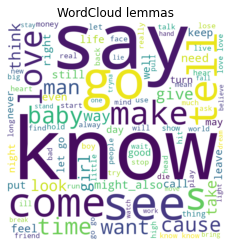

In [ ]:
lyrics_text = ' '.join(pd.read_csv('cleaned_songs.csv')['Lemmatizated lyrics'].apply(ast.literal_eval).apply(join_to_string))

wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(str(lyrics_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud lemmas")
plt.show()

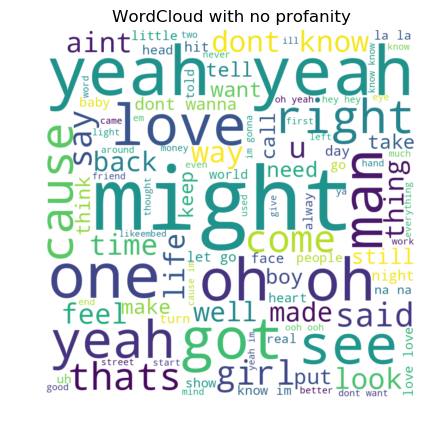

In [ ]:
df = pd.read_csv("cleaned_songs.csv")
lyrics_text = ' '.join(df['Cleaned Lyrics'])

wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(str(lyrics_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud with no profanity")
plt.show()

## Data Statistic per year

In [ ]:
data =  pd.read_csv('cleaned_songs.csv')
# Create a new DataFrame with the year, number of songs, number of unique words, and average number of words per song for each year
year_stats = pd.DataFrame(columns=['Year', 'Num Songs', 'Num Unique Words', 'Avg Words Per Song'])
for year in data['Year'].unique():
    year_data = data[data['Year'] == year]
    num_songs = len(year_data)
    all_words = []
    unique_words = set()
    for lyrics in year_data['Tokenized Lyrics']:
        all_words += lyrics
        unique_words.update(lyrics)
    num_unique_words = len(unique_words)
    avg_words_per_song = len(all_words) / num_songs
    year_stats = year_stats.append({'Year': year, 'Num Songs': num_songs, 'Num Unique Words': num_unique_words, 'Avg Words Per Song': avg_words_per_song}, ignore_index=True)

# Save the year_stats DataFrame to a CSV file
year_stats.to_csv('year_stats.csv', index=False)

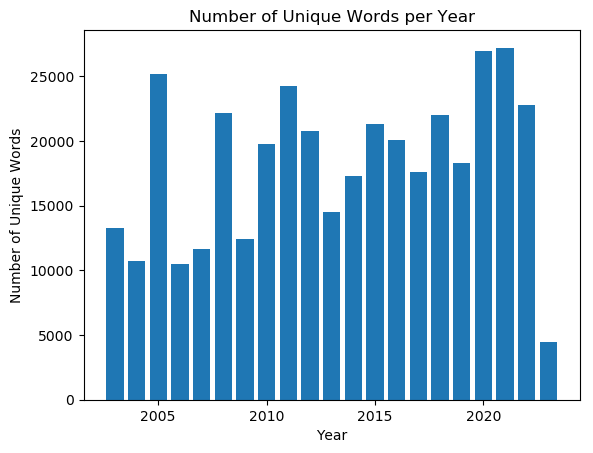

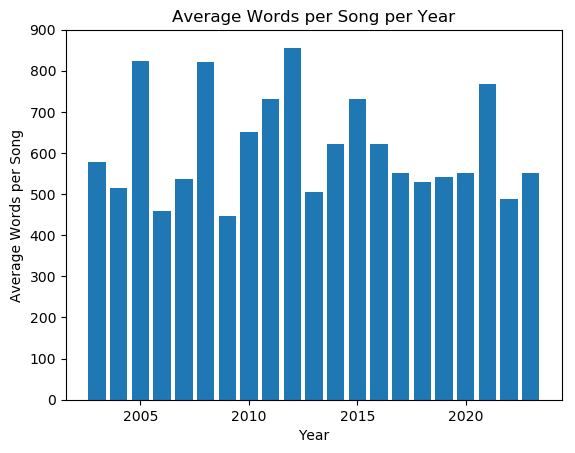

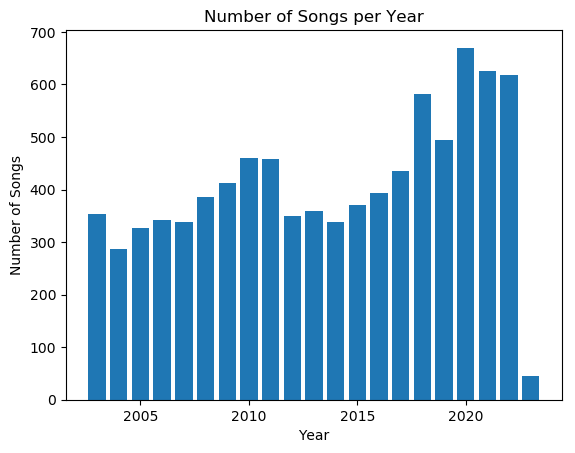

In [ ]:
# Plot the year_stats DataFrame as a bar chart
plt.bar(year_stats['Year'], year_stats['Num Unique Words'])
plt.title('Number of Unique Words per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Words')
plt.show()

plt.bar(year_stats['Year'], year_stats['Avg Words Per Song'])
plt.title('Average Words per Song per Year')
plt.xlabel('Year')
plt.ylabel('Average Words per Song')
plt.show()

plt.bar(year_stats['Year'], year_stats['Num Songs'])
plt.title('Number of Songs per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.show()

## LDA

In [ ]:
df = pd.read_csv("cleaned_songs.csv")['Lemmatizated lyrics'].apply(ast.literal_eval)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 11), (4, 1), (5, 1), (6, 27), (7, 4), (8, 26), (9, 3), (10, 2), (11, 10), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 4), (18, 1), (19, 10), (20, 1), (21, 1), (22, 1), (23, 2), (24, 4), (25, 4), (26, 1), (27, 4), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 6), (35, 1), (36, 6), (37, 12), (38, 6), (39, 1), (40, 2), (41, 4), (42, 1), (43, 2), (44, 4), (45, 1), (46, 1), (47, 9), (48, 1), (49, 5), (50, 2), (51, 2), (52, 1), (53, 3), (54, 1), (55, 7), (56, 4), (57, 13), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 5), (66, 1), (67, 1), (68, 4), (69, 1), (70, 1), (71, 1), (72, 1), (73, 8), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 4), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 2), (90, 4), (91, 2), (92, 1), (93, 3), (94, 1), (95, 1), (96, 1), (97, 1), (98, 3), (99, 1), (100, 1), (101, 5), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 1), (

In [ ]:
lda_models = dict()
num_topics_list = [5, 10, 15, 20, 25, 30]

# loop over the candidate numbers of topics
for num_topics in num_topics_list:
    # train an LDA model with the current number of topics
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    lda_models[num_topics] = lda_model
    # compute perplexity
    perplexity = lda_model.log_perplexity(corpus)
    # evaluate the coherence of the topics
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=data_lemmatized,
                                     dictionary=id2word,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # print stats
    print(f"Number of topics: {num_topics} \nPerplexity: {perplexity:.4f} \nCoherence score: {coherence_score:.4f}")

Number of topics: 5 
Perplexity: -7.3549 
Coherence score: 0.3881
Number of topics: 10 
Perplexity: -7.4627 
Coherence score: 0.4145
Number of topics: 15 
Perplexity: -7.5456 
Coherence score: 0.3769
Number of topics: 20 
Perplexity: -7.6083 
Coherence score: 0.3840
Number of topics: 25 
Perplexity: -7.6736 
Coherence score: 0.3861
Number of topics: 30 
Perplexity: -7.7205 
Coherence score: 0.3763


In [ ]:
# Save the dictionary of LDA models to a pickle file
with open('models_lda_dict.pkl', 'wb') as f:
    pickle.dump(lda_models, f)

In [ ]:
with open('/content/models_lda_dict.pkl', 'rb') as f:
    models_dict = pickle.load(f)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(models_dict[20], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.338008  0.058963       1        1  22.361985
7      0.282382  0.197324       2        1  17.708758
18     0.245038 -0.179275       3        1  10.251333
19     0.057303  0.275198       4        1   8.346015
16     0.238769 -0.171797       5        1   8.249556
3      0.218842  0.031367       6        1   7.592927
5      0.145417 -0.128597       7        1   7.015786
2      0.141552 -0.025393       8        1   5.288636
6     -0.103684  0.031154       9        1   1.745321
11    -0.061983 -0.032130      10        1   1.503565
10    -0.107977  0.066456      11        1   1.390176
9     -0.157975  0.014764      12        1   1.153656
8     -0.156544 -0.021992      13        1   1.104020
12    -0.160955  0.017689      14        1   1.083151
4     -0.118523 -0.050490      15        1   1.029854
1     -0.146973 -0.050608      16        1   0.977573
13    -0.139664 -0.006079      17        1   0.931787
14    -0.163331  0.012611      18        1   0.848586
0     -0.184095 -0.022289      19        1   0.807297
17    -0.165607 -0.016876      20        1   0.610019, topic_info=             Term          Freq         Total Category  logprob  loglift
8              be  75954.000000  75954.000000  Default  30.0000  30.0000
34            get  38491.000000  38491.000000  Default  29.0000  29.0000
55           love  19314.000000  19314.000000  Default  28.0000  28.0000
108          want  15117.000000  15117.000000  Default  27.0000  27.0000
83            say  20460.000000  20460.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
54731    militare     60.498949     63.840425  Topic20  -5.2066   5.0457
54784       vario     60.498949     63.840425  Topic20  -5.2066   5.0457
54746      patrio     47.754085     51.957364  Topic20  -5.4431   5.0151
60     might_also    108.480704   5757.394350  Topic20  -4.6226   1.1278
87            son     45.314775    743.034644  Topic20  -5.4956   2.3023

[1071 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6935      4  0.997935   abandon
1248      4  0.998462      able
1322      6  0.984323     abuse
6938     11  0.989913    accent
6758      9  0.989069  acoustic
...     ...       ...       ...
191       7  0.945096     young
8180     15  0.989376   youngin
3509     14  0.987457     youth
8943     12  0.992599         z
4778     19  0.970439       zoo

[1852 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 8, 19, 20, 17, 4, 6, 3, 7, 12, 11, 10, 9, 13, 5, 2, 14, 15, 1, 18])

## Understanding lyrics with T5 transformer

### Prepare model



In [ ]:
torch.cuda.empty_cache()

In [ ]:
MODEL_NAME = 'igorktech/t5-base-en'
SAVE_MODEL_NAME = 't5-base-en-explainer-10ep'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 4
REPORT_STEPS = 250
EPOCHS = 10
LEARNING_RATE = 1e-4
TASK_PREFIX = "explain | "
MAX_INPUT = 64
MAX_OUTPUT = 64
SPLIT_SIZE = 0.05
RANDOM_STATE = 42
# model.config.max_length = MAX_OUTPUT #not mandatory
SAVE_TO_HUB = True

In [ ]:
if SAVE_TO_HUB: 
    notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Prepare pairs of text for training

In [ ]:
pairs = []
df =  pd.read_csv('cleaned_songs.csv')['Song annotations'].apply(ast.literal_eval)

for index in range(len(df)):
    for tup in df[index]:

        new_tup = (tup[0], re.sub(r'http\S+', '', tup[1][0][0]))
        pairs.append(new_tup)

# # create a new DataFrame with the new list of tuples
new_df = pd.DataFrame(pairs, columns=['Lyrics', 'Description'])

In [ ]:
new_df.to_csv('lyrics_annotation_pairs.csv',index = False)

In [ ]:
data = pd.read_csv('/content/lyrics_annotation_pairs.csv')

In [ ]:
data.dropna(subset=['Lyrics'])
data['Lyrics'] = data['Lyrics'].astype(str)
# Drop text in [brakets]
data = data[~data['Lyrics'].str.contains('^\[.*\]$')]
data.to_csv('lyrics_annotation_pairs.csv',index = False)

In [ ]:
data = pd.read_csv('/content/lyrics_annotation_pairs.csv')
#drop tokens that are more than max output
data = data[data['Description'].str.count(' ') < MAX_OUTPUT]

In [ ]:
pairs = []
for a, b in zip(data['Lyrics'].astype(str), data['Description'].astype(str)):
    pairs.append((TASK_PREFIX + a, b))

In [ ]:
print(len(pairs))

25376


In [ ]:
# Split data into train and validation sets
train_pairs, val_pairs = train_test_split(pairs, test_size=SPLIT_SIZE, random_state=RANDOM_STATE)

### Training loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Define training and validation functions
def train(model, optimizer, tokenizer, train_pairs):
    model.train()
    losses = []
    for i in trange(0, int(len(train_pairs) / TRAIN_BATCH_SIZE)):
        batch = train_pairs[i * TRAIN_BATCH_SIZE: (i + 1) * TRAIN_BATCH_SIZE]
        
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding="longest", \
                      max_length=MAX_INPUT, truncation=True).to(model.device)
        y = tokenizer([p[1] for p in batch], return_tensors='pt', padding="longest", \
                      max_length=MAX_OUTPUT, truncation=True, ).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        loss = model(
            input_ids=x.input_ids,
            attention_mask=x.attention_mask,
            labels=y.input_ids,
            decoder_attention_mask=y.attention_mask,
            return_dict=True
        ).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if i % REPORT_STEPS == 0:
            print('train step', i, 'loss', np.mean(losses[-REPORT_STEPS:]))
            
    # Return training losses for plotting
    return losses

def evaluate(model, tokenizer, val_pairs):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i in trange(0, int(len(val_pairs) / EVAL_BATCH_SIZE)):
            batch = val_pairs[i * EVAL_BATCH_SIZE: (i + 1) * EVAL_BATCH_SIZE]
            x = tokenizer([p[0] for p in batch], return_tensors='pt', padding="longest", \
                          max_length=MAX_INPUT, truncation=True).to(model.device)
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding="longest", \
                          max_length=MAX_OUTPUT, truncation=True, ).to(model.device)
            y.input_ids[y.input_ids == 0] = -100
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            total_loss += loss.item()
        avg_loss = total_loss / int(len(val_pairs) / EVAL_BATCH_SIZE)
        print('validation loss', avg_loss)
        return avg_loss

# Train the model for multiple epochs and store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    print('EPOCH', epoch)
    random.shuffle(train_pairs)
    train_loss = train(model, optimizer, tokenizer, train_pairs)
    val_loss = evaluate(model, tokenizer, val_pairs)
    train_losses += train_loss
    val_losses.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
        


EPOCH 0


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 16.5843505859375
train step 250 loss 8.322848833084107
train step 500 loss 6.753389699935913
train step 750 loss 6.3192446937561035
train step 1000 loss 5.595619508743286
train step 1250 loss 4.9913691215515135
train step 1500 loss 4.74365193939209


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.899836804212456
EPOCH 1


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 4.495316982269287
train step 250 loss 4.529373239517212
train step 500 loss 4.437258695602417
train step 750 loss 4.360051228523254
train step 1000 loss 4.27372808265686
train step 1250 loss 4.252272123336792
train step 1500 loss 4.204789909362793


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.6351714472665395
EPOCH 2


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.7745885848999023
train step 250 loss 4.144819268226623
train step 500 loss 4.095548265457153
train step 750 loss 4.055730417251587
train step 1000 loss 4.012120845794677
train step 1250 loss 3.995784059524536
train step 1500 loss 3.9806493701934813


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.495262934958521
EPOCH 3


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.8327651023864746
train step 250 loss 3.913915831565857
train step 500 loss 3.886298041343689
train step 750 loss 3.864501208305359
train step 1000 loss 3.8555385732650755
train step 1250 loss 3.8159267263412477
train step 1500 loss 3.816633270263672


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.4078712816870174
EPOCH 4


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.8811450004577637
train step 250 loss 3.753407753944397
train step 500 loss 3.728291400909424
train step 750 loss 3.7128928775787355
train step 1000 loss 3.72125546169281
train step 1250 loss 3.6846557960510253
train step 1500 loss 3.674808027267456


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.3375237318995623
EPOCH 5


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.5113730430603027
train step 250 loss 3.601335569381714
train step 500 loss 3.622811385154724
train step 750 loss 3.58326136302948
train step 1000 loss 3.5801876974105835
train step 1250 loss 3.5707424058914183
train step 1500 loss 3.555393550872803


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.287563031404176
EPOCH 6


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.3548941612243652
train step 250 loss 3.490725429534912
train step 500 loss 3.4940056161880495
train step 750 loss 3.4633903942108155
train step 1000 loss 3.4761395034790037
train step 1250 loss 3.4818002729415896
train step 1500 loss 3.4468893098831175


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.244287702187379
EPOCH 7


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.3688926696777344
train step 250 loss 3.401930543899536
train step 500 loss 3.376886258125305
train step 750 loss 3.380571467399597
train step 1000 loss 3.3763328008651734
train step 1250 loss 3.374392021179199
train step 1500 loss 3.3710003356933593


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.2018338370398394
EPOCH 8


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.160048484802246
train step 250 loss 3.2973461704254152
train step 500 loss 3.278227430343628
train step 750 loss 3.300633418083191
train step 1000 loss 3.2978701429367066
train step 1250 loss 3.2696103248596193
train step 1500 loss 3.278291071891785


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.1668781429435175
EPOCH 9


  0%|          | 0/1506 [00:00<?, ?it/s]

train step 0 loss 3.115722179412842
train step 250 loss 3.209090753555298
train step 500 loss 3.211885629653931
train step 750 loss 3.2021121158599852
train step 1000 loss 3.204491805076599
train step 1250 loss 3.2027669982910156
train step 1500 loss 3.208041234970093


  0%|          | 0/317 [00:00<?, ?it/s]

validation loss 3.1419910060870535


In [ ]:
# Save progress
df = pd.DataFrame({
    'train_loss': train_losses
})
df.to_csv('t5_train_loss.csv')
df = pd.DataFrame({
    'val_loss': val_losses
})
df.to_csv('t5_val_loss.csv')

### Save model

In [ ]:
if SAVE_TO_HUB:
    model.push_to_hub(SAVE_MODEL_NAME)
    tokenizer.push_to_hub(SAVE_MODEL_NAME)
else:
    model.save_pretrained(SAVE_MODEL_NAME)
    tokenizer.save_pretrained(SAVE_MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/916M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/597k [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

### Plot Losses

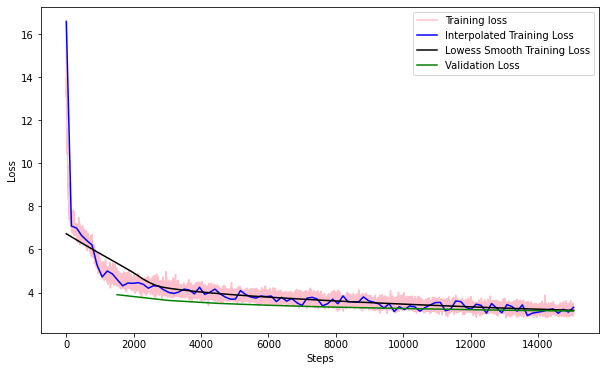

In [ ]:
# Plot 
plt.figure(figsize=(10, 6))
df = pd.read_csv('/content/t5_train_loss.csv')
plt.plot(df.iloc[:, 0],df['train_loss'],color = 'pink', label='Training loss')

f = interp1d(df.iloc[:, 0], df['train_loss'], kind='quadratic')
# create a new array of step values for the interpolated data
x_new = np.linspace(df.iloc[:, 0].min(), df.iloc[:, 0].max(), num=100)
# evaluate the interpolated function at the new step values
train_loss_interp = f(x_new)
plt.plot(x_new, train_loss_interp, color = 'blue', label='Interpolated Training Loss')

y_lowess = sm.nonparametric.lowess(df['train_loss'], df.iloc[:, 0], frac = 0.3)  # 30 % lowess smoothing
plt.plot(y_lowess[:, 0], y_lowess[:, 1], color = 'black', label = 'Lowess Smooth Training Loss')  # some noise removed

df = pd.read_csv('/content/t5_val_loss.csv')
plt.plot((df.iloc[:, 0]+1)*int(len(pairs)*(1-SPLIT_SIZE)/TRAIN_BATCH_SIZE), df['val_loss'], color = 'green', label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing model

In [ ]:
TEST_MODEL_NAME = 'igorktech/t5-base-en-explainer-10ep'
model = T5ForConditionalGeneration.from_pretrained(TEST_MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(TEST_MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
model.eval()

def explain(x, **kwargs):
    inputs = tokenizer(x, return_tensors='pt').to(model.device)
    with torch.no_grad():
        hypotheses = model.generate(**inputs, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [ ]:
print('prediction: ', explain(TASK_PREFIX + 'What is love?'))

prediction:  This is a reference to the song “What is Love?” by Drake.


In [ ]:
reference = [p[1].split(' ') for p in val_pairs]

In [ ]:
candidate = []

for p in tqdm(val_pairs):
  candidate.append(explain(TASK_PREFIX +p[0]).split(' '))

  0%|          | 0/1269 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame({'Reference':[p[1] for p in val_pairs], 'Candidate': [' '.join(c) for c in candidate]})
df.to_csv('t5_predictions.csv',index = False)

### BLEU score

In [ ]:
# Set weights for n-gram
weights = [(1, 0, 0, 0),  # 1-gram
           (0.5, 0.5, 0, 0),  # 2-gram
           (0.33, 0.33, 0.33, 0),  # 3-gram
           (0.25, 0.25, 0.25, 0.25)]  # 4-gram


# Compute BLEU score
grams_bleu_dict = dict()
for i in range(len(weights)):
  bleu_scores = []
  for j in range(len(reference)):
    bleu_scores.append(sentence_bleu([reference[j]], candidate[j], weights=weights[i]))
  grams_bleu_dict[i+1] = bleu_scores

# Save the dictionary of different BLEU to a pickle file
with open('t5_model_n_gram_bleu_dict.pkl', 'wb') as f:
    pickle.dump(grams_bleu_dict, f)

In [ ]:
with open('/content/t5_model_n_gram_bleu_dict.pkl', 'rb') as f:
    model_bleu_dict = pickle.load(f)

In [ ]:
for i in range(4):
  # Compute the mean of the BLEU scores using numpy:
  mean_bleu = np.mean(model_bleu_dict[i+1])
  # Compute average:
  avg_bleu = np.average(model_bleu_dict[i+1])
  print(f"Mean BLEU score for {i+1}-gram: ", mean_bleu)
  print(f"Average BLEU score for {i+1}-gram: ", avg_bleu)

Mean BLEU score for 1-gram:  0.05014265308566704
Average BLEU score for {i+1}-gram:  0.05014265308566704
Mean BLEU score for 2-gram:  0.014084229795258894
Average BLEU score for {i+1}-gram:  0.014084229795258894
Mean BLEU score for 3-gram:  0.00507945063775178
Average BLEU score for {i+1}-gram:  0.00507945063775178
Mean BLEU score for 4-gram:  0.0018883290628454446
Average BLEU score for {i+1}-gram:  0.0018883290628454446


### ROUGE score

In [ ]:
df = pd.read_csv('/content/t5_predictions.csv')

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(df['Candidate'], df['Reference'])
print("ROUGE: ", scores)
scores = rouge.get_scores(df['Candidate'], df['Reference'], avg=True)
print("AVG ROUGE: ", scores)

ROUGE:  [{'rouge-1': {'r': 0.10204081632653061, 'p': 0.5, 'f': 0.16949152260844588}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.08163265306122448, 'p': 0.4, 'f': 0.13559321752370013}}, {'rouge-1': {'r': 0.2692307692307692, 'p': 0.5833333333333334, 'f': 0.3684210483102493}, 'rouge-2': {'r': 0.1111111111111111, 'p': 0.2727272727272727, 'f': 0.15789473272853197}, 'rouge-l': {'r': 0.19230769230769232, 'p': 0.4166666666666667, 'f': 0.2631578904155125}}, {'rouge-1': {'r': 0.07407407407407407, 'p': 0.16666666666666666, 'f': 0.10256409830374771}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.07407407407407407, 'p': 0.16666666666666666, 'f': 0.10256409830374771}}, {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}, {'rouge-1': {'r': 0.15, 'p': 0.2727272727272727, 'f': 0.19354838251821027}, 'rouge-2': {'r': 0.041666666666666664, 'p': 0.09090909090909091, 'f': 0.05714285283265339}, 'r

## Word2Vec for lyrics analogy


### Skip-gram

In [2]:
import pandas as pd
import numpy as np
import pickle
import torch
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# decrease number of songs to speed up training
tokenized_corpus = pd.read_csv('/content/cleaned_songs.csv').sample(frac=1)['Tokenized Lyrics'][:1000]

In [21]:
# Save tokenized_corpus
with open('tokenized_corpus.pkl', 'wb') as f:
    pickle.dump(tokenized_corpus, f)

In [5]:
vocabulary = []
for sentence in tqdm(tokenized_corpus.tolist()):
    for token in sentence.split(' '):
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


In [6]:
# Save word2idx and idx2word
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)
with open('idx2word.pkl', 'wb') as f:
    pickle.dump(idx2word, f)
torch.save(vocabulary, 'vocabulary.pkl')

In [7]:
with open('/content/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)
with open('/content/idx2word.pkl', 'rb') as f:
    idx2word = pickle.load(f)
with open('/content/vocabulary.pkl', 'rb') as f:
    vocabulary = torch.load(f)
    vocabulary_size = len(vocabulary)

In [8]:
# assume relation between 2 words
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus.tolist():
    indices = [word2idx[word] for word in sentence.split(' ')]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # store as numpy array

In [9]:
torch.cuda.empty_cache()

In [10]:
# Define hyperparameters
EMBEDDING_DIMS = 128
VOCABULARY_SIZE = len(vocabulary)
NUM_EPOCHS = 5
BATCH_SIZE = 512*8*2
LEARNING_RATE = 0.01

In [11]:
def get_input_layer(word_idx):
    x = torch.zeros(VOCABULARY_SIZE, dtype=torch.float32).float()
    x[word_idx] = 1.0
    return x

### Training Loop

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Define model parameters and initialize randomly
W1 = torch.randn(EMBEDDING_DIMS, VOCABULARY_SIZE,device="cuda", requires_grad=True).to(device).float()
W2 = torch.randn(VOCABULARY_SIZE, EMBEDDING_DIMS,device="cuda", requires_grad=True).to(device).float()

# Train the model and save training loss to a table
training_loss = pd.DataFrame(columns=['epoch', 'loss'])

for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss = 0
    for i in tqdm(range(0, len(idx_pairs), BATCH_SIZE)):
        batch_pairs = idx_pairs[i:i+BATCH_SIZE]
        x = torch.cat([get_input_layer(data).unsqueeze(0) for data, _ in batch_pairs], dim=0).to(device)
        # x = torch.tensor([get_input_layer(data) for data, _ in batch_pairs], dtype=torch.float32).to(device)
        y_true = torch.tensor([target for _, target in batch_pairs], dtype=torch.long).to(device)

        z1 = torch.matmul(W1, x.t())
        z2 = torch.matmul(W2, z1)

        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.t(), y_true)
        total_loss += loss.item()
        loss.backward(retain_graph=True)


        with torch.no_grad():
            W1.add_(-LEARNING_RATE * W1.grad)
            W2.add_(-LEARNING_RATE * W2.grad)
            # W1 -= LEARNING_RATE * W1.grad
            # W2 -= LEARNING_RATE * W2.grad
            W1.grad.zero_()
            W2.grad.zero_()

    if epoch % 2 == 0:    
        print(f'Loss at epoch {epoch}: {total_loss/len(idx_pairs)}')
    training_loss = training_loss.append({'epoch': epoch, 'train_loss': total_loss/len(idx_pairs)}, ignore_index=True)

# Save the trained model and vocabulary
torch.save(W1, 'embedding_weights.pt')
torch.save(vocabulary, 'vocabulary.pkl')
# Save training loss to a CSV file
training_loss.to_csv('skip_gram_training_loss.csv', index=False)

# Save the trained model and vocabulary
torch.save(W1, '/content/drive/MyDrive/w2v/embedding_weights.pt')
torch.save(vocabulary, '/content/drive/MyDrive/w2v/vocabulary.pkl')
# Save training loss to a CSV file
training_loss.to_csv('/content/drive/MyDrive/w2v/skip_gram_training_loss.csv', index=False)




100%|██████████| 386/386 [08:49<00:00,  1.37s/it]
<ipython-input-13-a7ae68609f76>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_loss = training_loss.append({'epoch': epoch, 'train_loss': total_loss/len(idx_pairs)}, ignore_index=True)
 20%|██        | 1/5 [08:49<35:16, 529.10s/it]

Loss at epoch 0: 0.005646993028326748



100%|██████████| 386/386 [08:31<00:00,  1.33s/it]
<ipython-input-13-a7ae68609f76>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_loss = training_loss.append({'epoch': epoch, 'train_loss': total_loss/len(idx_pairs)}, ignore_index=True)
100%|██████████| 386/386 [08:47<00:00,  1.37s/it]
<ipython-input-13-a7ae68609f76>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_loss = training_loss.append({'epoch': epoch, 'train_loss': total_loss/len(idx_pairs)}, ignore_index=True)
100%|██████████| 386/386 [08:29<00:00,  1.32s/it]
<ipython-input-13-a7ae68609f76>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_loss = training_loss.append({'epoch': epoch, 'train_loss': total_loss/len(idx_pairs)}, ignore_ind

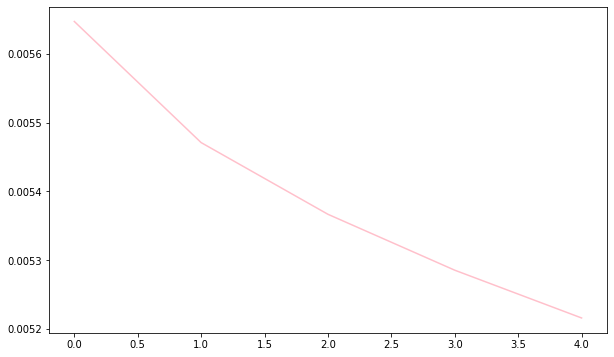

In [16]:
# Plot 
plt.figure(figsize=(10, 6))
df = pd.read_csv('/content/skip_gram_training_loss.csv')
plt.plot(df['epoch'],df['train_loss'],color = 'pink', label='Training loss')

In [25]:
def word_analogy(model_path, vocab_path, word1, word2, word3):
    # Load the trained word embedding model and vocabulary
    W1 = torch.load(model_path)
    vocabulary = torch.load(vocab_path)

    # Get the indices of the three input words
    try:
      indices = [vocabulary.index(word.lower()) for word in [word1.lower(), word2.lower(), word3.lower()]]
    except:
      return None
    # Convert the input words to dense embedding vectors
    x1 = W1[:, indices[0]]
    x2 = W1[:, indices[1]]
    x3 = W1[:, indices[2]]

    # Compute the vector difference and add it to the fourth word's vector
    x4 = x2 - x1 + x3
    print(x4)
    # Find the index of the closest word to the resulting vector
    sim_scores = torch.matmul(W1.T, x4)
    _, closest_word_idx = sim_scores.max(dim=0)

    # Return the closest word
    closest_word = vocabulary[closest_word_idx]
    return closest_word

In [35]:
word_analogy('/content/embedding_weights.pt','/content/vocabulary.pkl','cash','bank','money')

tensor([ 1.6587, -0.9130, -1.7776,  1.2808, -2.4178, -1.8317,  0.7058, -1.1076,
        -1.4333, -0.2983, -0.3548,  1.3404,  2.1815, -2.8978,  0.9021, -3.4068,
        -2.6570,  1.7988, -0.0355, -0.1161,  2.0333, -0.0257,  1.8281, -0.3801,
         0.2266, -0.9656,  0.2546, -0.1516,  4.1168, -0.3922, -0.0986,  0.1572,
        -1.4179,  0.0489,  3.6452, -4.0343, -1.0422, -0.2144,  2.0721,  1.9454,
        -1.3409, -0.9607, -2.7030, -1.1126,  1.4479, -0.4242,  1.3730, -0.6959,
         0.7685, -0.5063,  0.3442,  0.7361, -0.7204,  0.7242, -2.7095, -2.0312,
         0.7206, -0.9392, -1.1173, -1.4623, -1.1496,  1.5866,  0.8818,  2.3637,
         1.8047,  2.5201,  3.5334, -1.7056,  0.5423,  2.4502,  1.5773, -1.2409,
         2.5725,  3.2447,  2.3903,  3.2573, -2.1807,  0.7387,  1.1773,  0.8024,
         0.5141,  0.8563, -2.0222,  1.4100,  3.7898,  2.7276, -3.3494,  2.0846,
         0.7336,  2.4868, -1.1091,  0.5554,  1.6864, -0.7966, -2.8555, -0.1245,
        -1.4982, -1.7115,  3.1966, -0.63

'bank'

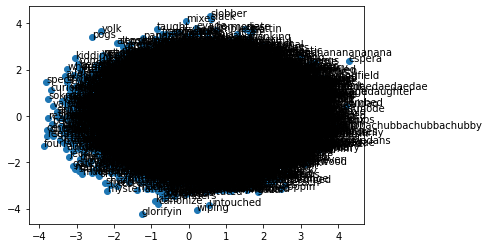

In [19]:
# Load the trained word embedding model and vocabulary
W1 = torch.load('/content/embedding_weights.pt')
vocabulary = torch.load('/content/vocabulary.pkl')

# Convert the embedding matrix to a numpy array
W1_np = W1.detach().cpu().numpy()

# Use PCA to reduce the dimensionality of the embeddings to 2D
pca = PCA(n_components=2)
W1_2d = pca.fit_transform(W1_np.T)

# Plot the embeddings in 2D space
fig, ax = plt.subplots()
ax.scatter(W1_2d[:, 0], W1_2d[:, 1])

# Add word labels to the plot
for i, word in enumerate(vocabulary):
    ax.annotate(word, (W1_2d[i, 0], W1_2d[i, 1]))

plt.show()

/Users/macbook_pro/Documents/GitHub/lyrics-sentiment-analysis/venv/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


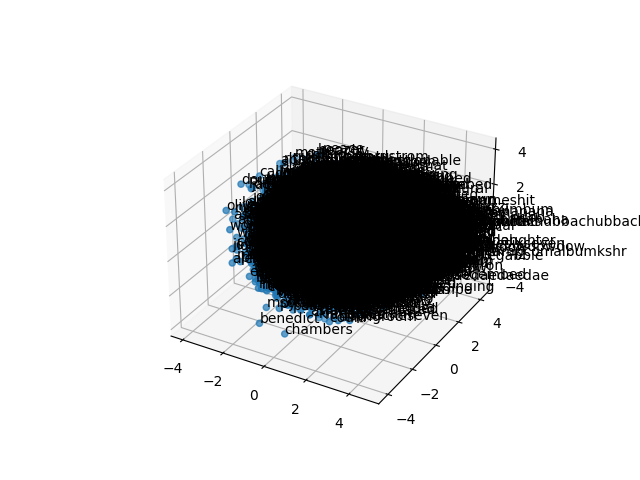

In [54]:
W1 = torch.load('embedding_weights.pt', map_location=torch.device(device))
vocabulary = torch.load('vocabulary.pkl')

W1_np = W1.detach().cpu().numpy()

# Use PCA to reduce the dimensionality of the embeddings to 3D
pca = PCA(n_components=3)
W1_3d = pca.fit_transform(W1_np.T)

# Plot the embeddings in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(W1_3d[:, 0], W1_3d[:, 1], W1_3d[:, 2])

# Add word labels to the plot
for i, word in enumerate(vocabulary):
    ax.text(W1_3d[i, 0], W1_3d[i, 1], W1_3d[i, 2], word)

# Add interactive zooming
def on_move(event):
    if event.inaxes == ax:
        ax.format_coord = lambda x, y: f"x={x:.2f}, y={y:.2f}, z={ax.get_zlim()}"
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_move)
# plt.xlim(0.3, 1.0)
# plt.ylim(0.3, 1.0)
plt.show()

/Users/macbook_pro/Documents/GitHub/lyrics-sentiment-analysis/venv/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


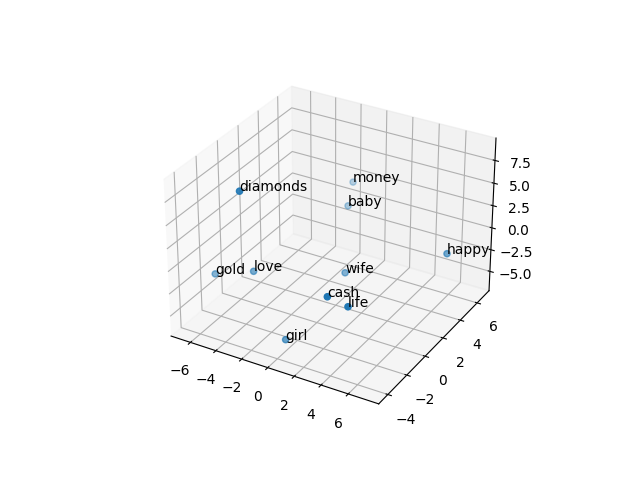

In [55]:
# Load the trained word embedding model and vocabulary
W1 = torch.load('embedding_weights.pt', map_location=torch.device(device))
vocabulary = torch.load('vocabulary.pkl')

vocab= ['love','happy','life','wife','baby','girl', 'money', 'cash', 'gold', 'diamonds']
vocabulary_indices = []
for word in vocab:
    vocabulary_indices.append(vocabulary.index(word))


W1_vocabulary = W1[:,vocabulary_indices]

# Convert the embedding matrix to a numpy array
W1_np = W1_vocabulary.detach().cpu().numpy()

# Use PCA to reduce the dimensionality of the embeddings to 3D
pca = PCA(n_components=3)
W1_3d = pca.fit_transform(W1_np.T)

# Plot the embeddings in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(W1_3d[:, 0], W1_3d[:, 1], W1_3d[:, 2])

# Add word labels to the plot
for i, word in enumerate(vocabulary):
    if i in vocabulary_indices:
        ax.text(W1_3d[vocabulary_indices.index(i), 0],
                W1_3d[vocabulary_indices.index(i), 1],
                W1_3d[vocabulary_indices.index(i), 2], word)
# plt.xlim(2.3, 1.0)
# plt.ylim(2.3, 1.0)
plt.show()
mpld3.enable_notebook()